In [1]:
import harmonypy as hm
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import umap
import sklearn.neighbors
import sklearn.metrics
import itertools
import glob
from pathlib import Path

%matplotlib inline

In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local","")

    wk_dir = base_dir + "/0_Combined"
    Path(wk_dir).mkdir(parents=True, exist_ok=True)
else:
    print("Reload")

Start


In [264]:
root_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC'
plot_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/6_Harmony'
os.chdir(wk_dir)

-----

## 0. Pre Process Inputs

In [4]:
###----- Normalized to 10e4 per cell --> Log natural base (x+1)
exp391_expr_scaled_file = root_dir + \
    '/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/counts_XL_folder/all_norm_counts_named_log_scaled.csv'
exp334_expr_scaled_file = root_dir + \
    '/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/counts_XL_folder/all_norm_counts_named_log_scaled.csv'

exp391_expr_scaled_tb = pd.read_csv(exp391_expr_scaled_file)
exp334_expr_scaled_tb = pd.read_csv(exp334_expr_scaled_file)

# Unify column names
exp391_expr_scaled_tb.columns = ["cell_id"] +  list(exp391_expr_scaled_tb.columns)[1:]
exp334_expr_scaled_tb.columns = ["cell_id"] +  list(exp334_expr_scaled_tb.columns)[1:]

In [5]:
###----- Read obs files, select highly variable genes & used cells
#Analyzed cells
exp391_obs = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga/obs.csv'
exp334_obs = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/1_IL2RAKO_paga/obs.csv'

exp391_obs_tb = pd.read_csv(exp391_obs)
exp334_obs_tb = pd.read_csv(exp334_obs)

exp391_obs_tb.columns = ['cell_id'] + list(exp391_obs_tb.columns)[1:]
exp334_obs_tb.columns = ['cell_id'] + list(exp334_obs_tb.columns)[1:]

exp391_obs_tb = exp391_obs_tb[['cell_id','cell_type','louvain']]
exp334_obs_tb = exp334_obs_tb[['cell_id','cell_type','louvain']]

exp391_obs_tb['dataset'] = ['Exp391' for x in exp391_obs_tb['cell_id']]
exp334_obs_tb['dataset'] = ['Exp334' for x in exp334_obs_tb['cell_id']]

all_usedCells_meta = pd.concat([exp391_obs_tb, exp334_obs_tb])

In [6]:
###----- Select cells & Genes for analysis
# Find all highly variable genes that are present in all datasets
use_cols = list(exp391_expr_scaled_tb.columns)[1:]
use_cols = list(set(use_cols) & set(list(exp334_expr_scaled_tb.columns)[1:]))
use_cols = ['cell_id'] + use_cols

exp391_expr_scaled_tb = exp391_expr_scaled_tb.loc[exp391_expr_scaled_tb['cell_id'].
                                                  isin(list(exp391_obs_tb['cell_id']))]
exp334_expr_scaled_tb = exp334_expr_scaled_tb.loc[exp334_expr_scaled_tb['cell_id'].
                                                  isin(list(exp334_obs_tb['cell_id']))]

exp391_expr_scaled_tb = exp391_expr_scaled_tb[use_cols]
exp334_expr_scaled_tb = exp334_expr_scaled_tb[use_cols]

all_expr_scaled_tb = pd.concat([exp391_expr_scaled_tb, exp334_expr_scaled_tb])

In [7]:
###----- Creat metadata
exp391_meta = pd.DataFrame({'cell_id':list(exp391_expr_scaled_tb['cell_id'])})
exp391_meta = pd.merge(exp391_meta, exp391_obs_tb, on='cell_id', how='left')
exp334_meta = pd.DataFrame({'cell_id':list(exp334_expr_scaled_tb['cell_id'])})
exp334_meta = pd.merge(exp334_meta, exp334_obs_tb, on='cell_id', how='left')

exp391_meta = exp391_meta[['cell_id','cell_type']]
exp334_meta = exp334_meta[['cell_id','cell_type']]

exp391_meta['dataset'] = ['Exp391' for x in exp391_meta['cell_id']]
exp334_meta['dataset'] = ['Exp334' for x in exp334_meta['cell_id']]

# Check if meta order match with data order
check_order_391 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp391_meta['cell_id'], exp391_expr_scaled_tb['cell_id']))]
check_order_334 = [0 if x == y else 1 for index, (x, y) in 
                   enumerate(zip(exp334_meta['cell_id'], exp334_expr_scaled_tb['cell_id']))]
print(np.sum(check_order_391 + check_order_334))

all_meta = pd.concat([exp391_meta, exp334_meta])

0


In [8]:
expr_scaled_file = "counts_XL_folder/Exp391_Exp334--normLog_highly_variable_scaled.csv"
meta_file = "Exp391_Exp334--normLog_highly_variable--Meta.csv"
meta_usedCells_file = "Exp391_Exp334--normLog_highly_variable--MetaUsedCells.csv"
all_expr_scaled_tb.to_csv(expr_scaled_file, index=False)
all_meta.to_csv(meta_file, index=False)
all_usedCells_meta.to_csv(meta_usedCells_file, index=False)

*Creat label reference*

In [66]:
exp391_louvain_avg = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/pt_ordered_cluster_avg.csv'
exp391_louvain_avg_tb = pd.read_csv(exp391_louvain_avg)[['louvain','louvain_new_label']]

exp334_louvain_avg = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
exp334_louvain_avg_tb = pd.read_csv(exp334_louvain_avg)[['louvain','louvain_new_label']]

exp391_louvain_avg_tb.columns = ['old_label', 'new_label']
exp334_louvain_avg_tb.columns = ['old_label', 'new_label']

exp391_louvain_avg_tb.to_csv("Exp391_newLabels.csv", index=False)
exp334_louvain_avg_tb.to_csv("Exp334_newLabels.csv", index=False)

## 1. Read input

In [10]:
expr_scaled_file = "counts_XL_folder/Exp391_Exp334--normLog_highly_variable_scaled.csv"
meta_file = "Exp391_Exp334--normLog_highly_variable--Meta.csv"
meta_usedCells_file = "Exp391_Exp334--normLog_highly_variable--MetaUsedCells.csv"

expr_scaled_tb = pd.read_csv(expr_scaled_file)
meta_tb = pd.read_csv(meta_file)
usedCells_meta_tb = pd.read_csv(meta_usedCells_file)
usedCells_meta_tb['ds_id'] = ["_".join([x, y]) for index, (x,y) in enumerate(zip(usedCells_meta_tb['dataset'], usedCells_meta_tb['cell_id']))]
usedCells_meta_tb['louvain'] = [str(x) for x in usedCells_meta_tb['louvain']]

print(expr_scaled_tb.shape)
print(meta_tb.shape)
print(usedCells_meta_tb.shape)

(9480, 2661)
(9480, 3)
(9480, 5)


In [11]:
expr_scaled_tb.head()

,cell_id,Ier2,Cyp4f18,Ltb,Hsdl1,Tex9,H2-Eb1,Tlr1,Twnk,Rsrp1,...,Akap7,Bbx,Ccs,Trim59,Tbcel,Bcl2a1b,Filip1l,Gxylt1,Ly6c2,Ifnar1
0,AAACCCAAGAGGCGTT-1,0.243121,-0.089406,0.166336,-0.430530,-0.339861,-0.145347,-0.251254,-0.204291,1.293390,...,-0.082411,1.542421,-0.620514,1.363438,-0.541890,1.518805,-0.429360,-0.542576,-0.334952,1.964941
1,AAACCCACAATGACCT-1,-0.412610,-0.009177,-0.089378,0.494451,-0.395273,-0.017400,-0.021571,1.362159,0.715578,...,-0.044232,0.269529,-0.447263,0.134236,-0.237142,0.336544,0.646094,-0.556012,-1.567363,1.059338
2,AAACCCACACGACAAG-1,-0.290688,-0.087817,1.738173,-0.429522,-0.340958,-0.142813,-0.246705,-0.205010,-0.772022,...,-0.081655,-0.614219,-0.617082,-0.655754,1.876707,-1.197253,2.236883,-0.542842,-1.931339,0.874304
3,AAACCCACAGAGGTAC-1,0.264357,-0.097651,-1.842048,-0.435762,-0.334167,-0.158495,-0.274856,-0.200558,1.938958,...,-0.086334,-0.647117,2.585133,3.449765,-0.573207,0.471379,-0.457392,2.717644,0.845146,-0.874968
4,AAACCCACAGCCGTTG-1,0.604035,-0.095432,-0.599354,-0.434354,-0.335699,-0.154957,-0.268505,-0.201562,1.724124,...,-0.085279,-0.639695,-0.633526,-0.630366,-0.564780,1.578190,-0.449849,-0.541566,0.880726,1.370506


In [12]:
meta_tb.head()

,cell_id,cell_type,dataset
0,AAACCCAAGAGGCGTT-1,C8P,Exp391
1,AAACCCACAATGACCT-1,C5P,Exp391
2,AAACCCACACGACAAG-1,NP14B,Exp391
3,AAACCCACAGAGGTAC-1,A8T,Exp391
4,AAACCCACAGCCGTTG-1,A8T,Exp391


In [13]:
usedCells_meta_tb.head()

,cell_id,cell_type,louvain,dataset,ds_id
0,AAACCCAAGAGGCGTT-1,C8P,8,Exp391,Exp391_AAACCCAAGAGGCGTT-1
1,AAACCCACAATGACCT-1,C5P,6,Exp391,Exp391_AAACCCACAATGACCT-1
2,AAACCCACACGACAAG-1,NP14B,3,Exp391,Exp391_AAACCCACACGACAAG-1
3,AAACCCACAGAGGTAC-1,A8T,2,Exp391,Exp391_AAACCCACAGAGGTAC-1
4,AAACCCACAGCCGTTG-1,A8T,7,Exp391,Exp391_AAACCCACAGCCGTTG-1


## 2. Run PCA

In [14]:
expr_scaled_tb = expr_scaled_tb.set_index("cell_id")
expr_scaled_arr = expr_scaled_tb.to_numpy()

pca = PCA(n_components=30)
pca.fit(expr_scaled_arr)
expr_scaled_arr_pca = pca.fit_transform(expr_scaled_arr)

expr_scaled_arr_pca.shape

(9480, 30)

<BarContainer object of 30 artists>

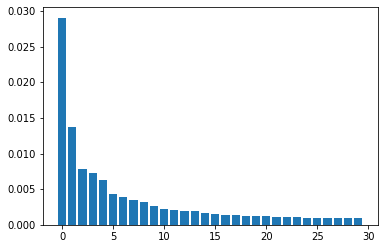

In [15]:
# Explained variance
plt.bar(list(range(0, 30)), pca.explained_variance_ratio_[:30])

### Experiments overlaop

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

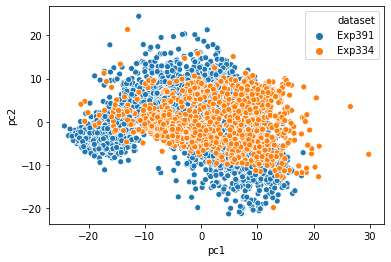

In [16]:
plot_tb = pd.DataFrame({'pc1':expr_scaled_arr_pca[:,0], 'pc2':expr_scaled_arr_pca[:,1], 
                        'pc3':expr_scaled_arr_pca[:,2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset')

<AxesSubplot:xlabel='pc2', ylabel='pc3'>

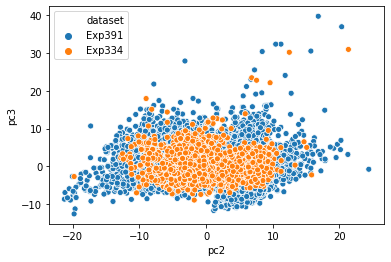

In [17]:
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset')

-----

## 2. Run Harmony

In [18]:
time.pre = time.time()
ho = hm.run_harmony(expr_scaled_arr_pca, meta_tb, ['dataset'])
time.post = time.time()

runtime = time.post - time.pre
print("Total Runtime in seconds: %s"%runtime)

2020-11-18 14:02:32,192 - harmonypy - INFO - Iteration 1 of 10
2020-11-18 14:02:33,590 - harmonypy - INFO - Iteration 2 of 10
2020-11-18 14:02:35,018 - harmonypy - INFO - Iteration 3 of 10
2020-11-18 14:02:36,440 - harmonypy - INFO - Iteration 4 of 10
2020-11-18 14:02:37,863 - harmonypy - INFO - Iteration 5 of 10
2020-11-18 14:02:39,287 - harmonypy - INFO - Iteration 6 of 10
2020-11-18 14:02:40,712 - harmonypy - INFO - Converged after 6 iterations


Total Runtime in seconds: 10.413957118988037


In [19]:
###----- Save output
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
res.to_csv("adj.tsv.gz", sep = "\t", index = False)

### Experiments overlap

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

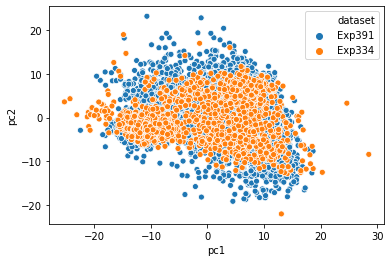

In [20]:
plot_tb = pd.DataFrame({'pc1':ho.Z_corr[0], 'pc2':ho.Z_corr[1], 
                        'pc3':ho.Z_corr[2], 'dataset':meta_tb['dataset']})
sns.scatterplot(data=plot_tb, x='pc1', y='pc2', hue='dataset')

<AxesSubplot:xlabel='pc2', ylabel='pc3'>

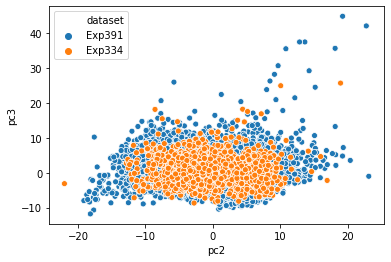

In [21]:
sns.scatterplot(data=plot_tb, x='pc2', y='pc3', hue='dataset')

-----

## 2. Run UMAP with Hamony adjusted PCs

In [174]:
reducer = umap.UMAP(n_neighbors = 250, random_state=123)
umap_embedding = reducer.fit_transform(ho.Z_corr.transpose())

In [202]:
reducer_graph = pd.DataFrame.sparse.from_spmatrix(reducer.graph_)

### Plot UMAP projection

In [267]:
plot_tb = pd.DataFrame(umap_embedding)
plot_tb['dataset'] = meta_tb['dataset']
plot_tb['cell_id'] = meta_tb['cell_id']
NAV_names = ['NP14B', 'NAV','P14NAV']
NAV_ACT = ['NAV' if x in NAV_names else 'ACT' for x in meta_tb['cell_type']]
plot_tb['NAV_ACT'] = NAV_ACT

plot_tb['ds_id'] = ["_".join([x, y]) for index, (x,y) in enumerate(zip(plot_tb['dataset'], plot_tb['cell_id']))]
usedCells_meta_tb_toAdd = usedCells_meta_tb[['ds_id', 'louvain']]

plot_tb = pd.merge(plot_tb, usedCells_meta_tb_toAdd, on='ds_id', how='left')

*Convert labels*

In [268]:
exp391_label_tb = pd.read_csv("Exp391_newLabels.csv")
exp334_label_tb = pd.read_csv("Exp334_newLabels.csv")
old_labels = ["Exp391_%s"%x for x in exp391_label_tb['old_label']] + \
             ["Exp334_%s"%x for x in exp334_label_tb['old_label']]

new_labels = ["Exp391_%s"%x for x in exp391_label_tb['new_label']] + \
             ["Exp334_%s"%x for x in exp334_label_tb['new_label']]


plot_tb_old_label = ["%s_%s"%(str(x), str(y)) for index, (x,y) in enumerate(zip(list(plot_tb['dataset']), plot_tb['louvain']))]
plot_tb_new_label = [new_labels[old_labels.index(x)] for x in plot_tb_old_label]

plot_tb['louvain_oldLabel'] = list(plot_tb['louvain'])
plot_tb['dataset_louvain'] = plot_tb_new_label
plot_tb['louvain'] = [x.split("_")[1] for x in plot_tb['dataset_louvain'] ]

*Before / after outlier removal*

<AxesSubplot:xlabel='0', ylabel='1'>

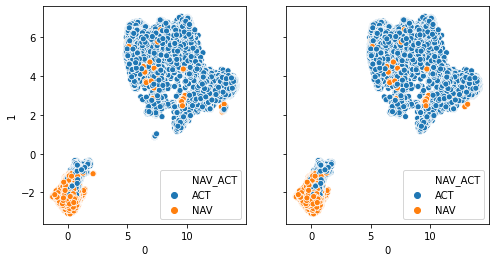

In [177]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb, x=0, y=1, hue='NAV_ACT', ax=ax1)

outlier_scores = sklearn.neighbors.LocalOutlierFactor(n_neighbors = 200, contamination=0.01).fit_predict(umap_embedding)
plot_tb['outlier_scores'] = outlier_scores
plot_tb_rmOutliers = plot_tb[plot_tb['outlier_scores'] != -1]
sns.scatterplot(data=plot_tb_rmOutliers, x=0, y=1, hue='NAV_ACT', ax=ax2)

*NAV v.s. ACT seperate*

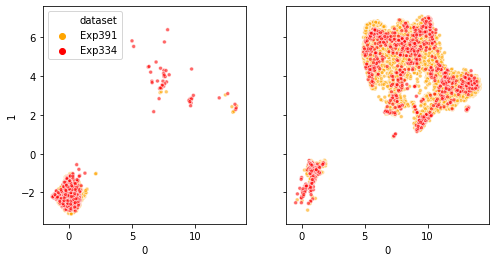

In [269]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb[plot_tb['NAV_ACT']=='NAV'], x=0, y=1, hue='dataset', 
                ax=ax1, palette=['orange', 'red'], alpha=0.6, s=15)
s2 = sns.scatterplot(data=plot_tb[plot_tb['NAV_ACT']=='ACT'], x=0, y=1, hue='dataset', 
                ax=ax2, palette=['orange', 'red'], alpha=0.6, s=15)
s2.legend([],[],frameon=False)
fig.savefig("%s/Exp391_Exp334_Harmony-UMAP_Naive_vs_Act.png"%plot_dir)

*All experiments*

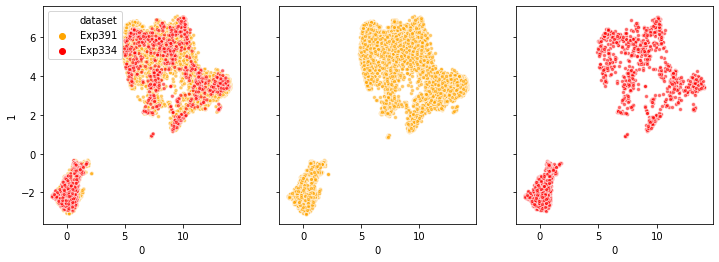

In [270]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))
sns.scatterplot(data=plot_tb, x=0, y=1, hue='dataset', ax=ax1, palette = ["orange", "red"], alpha=0.6, s=15)
sns.scatterplot(data=plot_tb[plot_tb['dataset']=='Exp391'], x=0, y=1, ax=ax2, color="orange", alpha=0.6, s=15)
sns.scatterplot(data=plot_tb[plot_tb['dataset']=='Exp334'], x=0, y=1, ax=ax3, color="red", alpha=0.6, s=15)
fig.savefig("%sExp391_Exp334_overlay.png"%plot_dir)

*Louvain*

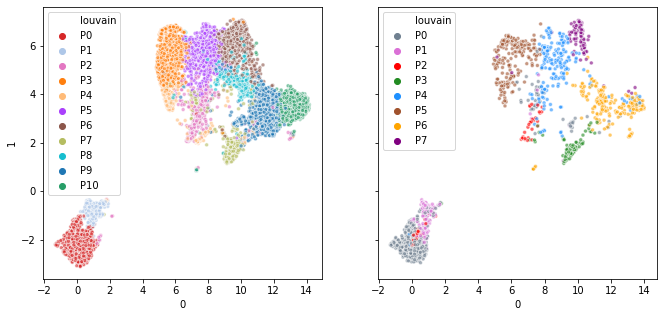

In [271]:
plot_tb['louvain'] = [x.split(".")[0] for x in plot_tb['louvain']]

plot_tb_391_louvain = plot_tb[plot_tb['dataset']=='Exp391']
plot_tb_334_louvain = plot_tb[plot_tb['dataset']=='Exp334']

plot_tb_391_louvain = plot_tb_391_louvain[plot_tb_391_louvain['louvain'] != 'nan']
plot_tb_334_louvain = plot_tb_334_louvain[plot_tb_334_louvain['louvain'] != 'nan']

hue_order_391 = exp391_label_tb['new_label'].tolist()
hue_order_334 = exp334_label_tb['new_label'].tolist()

hue_order_334 = list(set([x.split(".")[0] for x in hue_order_334]))
hue_order_334.sort()

pal_391 = ['#d62728', '#aec7e8', '#e377c2', '#ff7f0e', '#ffbb78', '#aa40fc', 
           '#8c564b', '#b5bd61', '#17becf', '#1f77b4', '#279e68']
pal_334 = ['slategray', 'orchid', 'red', 
           'forestgreen', 'dodgerblue', 'sienna', 'orange', 'purple']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(11, 5))
sns.scatterplot(data=plot_tb_391_louvain, x=0, y=1, hue='louvain', 
                ax=ax1, hue_order = hue_order_391, palette=pal_391, alpha=0.6, s=15)
sns.scatterplot(data=plot_tb_334_louvain, x=0, y=1, hue='louvain', 
                ax=ax2, hue_order = hue_order_334, palette=pal_334, alpha=0.6, s=15)
fig.savefig("%s/Exp391_Exp334_Harmony-UMAP_louvain.png"%plot_dir)
plt.show()
plt.close()

In [272]:
# Calculate average NN probabiligy between clusters in different experiments
exps_dict = {'Exp391': plot_tb_391_louvain, 'Exp334': plot_tb_334_louvain}
exps_label_dict = {'Exp391': hue_order_391, 'Exp334': hue_order_334}

for i, j in itertools.combinations(['Exp391', 'Exp334'], 2):
    i_tb = exps_dict[i]
    j_tb = exps_dict[j]

    i_labels = exps_label_dict[i]
    j_labels = exps_label_dict[j]
    i_j_s_tb = pd.DataFrame({"Cluster": ["%s_%s"%(i, x) for x in i_labels]})

    for j_label in j_labels:
        j_col = []
        for i_label in i_labels:
            
            i_index = [index for index, x in enumerate(plot_tb['dataset_louvain'].tolist()) if x == "%s_%s"%(i, i_label)]
            j_index = [index for index, x in enumerate(plot_tb['dataset_louvain'].tolist()) if x == "%s_%s"%(j, j_label)]
            
            i_j_s = reducer_graph[i_index].loc[j_index].stack().mean()
            
            j_col.append(i_j_s)
        i_j_s_tb["%s_%s"%(j, j_label)] = j_col

    i_j_s_tb_name = "%s/%s_%s_graphNNp.csv"%(plot_dir,i, j)
    i_j_s_tb.to_csv(i_j_s_tb_name, index=False)

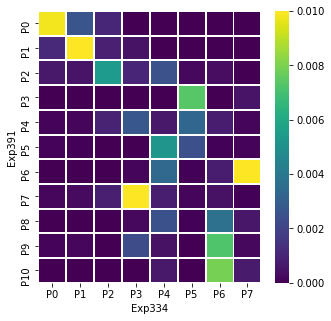

In [276]:
# Heatmap
S391_334 = "%s/Exp391_Exp334_graphNNp.csv"%plot_dir
S391_334_tb = pd.read_csv(S391_334)

S391_334_tb['Cluster'] = [x.split("_")[-1] for x in S391_334_tb['Cluster']]


S391_334_tb.columns = [x.split("_")[-1] for x in list(S391_334_tb.columns)]


S391_334_tb = S391_334_tb.set_index("Cluster")


fig, ax = plt.subplots(1, figsize=(5, 5))
sns.heatmap(S391_334_tb, cmap="viridis", ax=ax, linewidths=1, vmin=0, vmax=0.01)
ax.set(xlabel='Exp334', ylabel='Exp391')
fig.savefig("%s/Exp334_Exp391_cluster_graphNNp.png"%plot_dir)

plt.show()
plt.close()

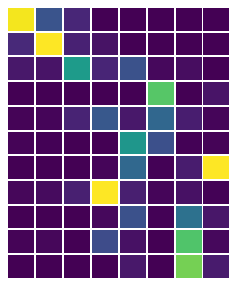

In [275]:
fig, ax = plt.subplots(1, figsize=(4, 5))
sns.heatmap(S391_334_tb, cmap="viridis", ax=ax, linewidths=1, vmin=0, vmax=0.01,
           xticklabels=False, yticklabels=False, cbar=False)
ax.set(xlabel='', ylabel='')
fig.savefig("%s/Exp334_Exp391_cluster_graphNNp_nolabels.png"%plot_dir)

-----

## 2. Run UMAP with original PCs

In [96]:
reducer = umap.UMAP(n_neighbors = 250, random_state=123)
umap_embedding_originalPCs = reducer.fit_transform(expr_scaled_arr_pca)

### Plot UMAP projection

In [97]:
plot_tb_op = pd.DataFrame(umap_embedding_originalPCs)
plot_tb_op['dataset'] = meta_tb['dataset']
NAV_names = ['NP14B', 'NAV','P14NAV']
NAV_ACT = ['NAV' if x in NAV_names else 'ACT' for x in meta_tb['cell_type']]
plot_tb_op['NAV_ACT'] = NAV_ACT
plot_tb_op['dataset'] = meta_tb['dataset']

*Before / after outlier removal*

<AxesSubplot:xlabel='0', ylabel='1'>

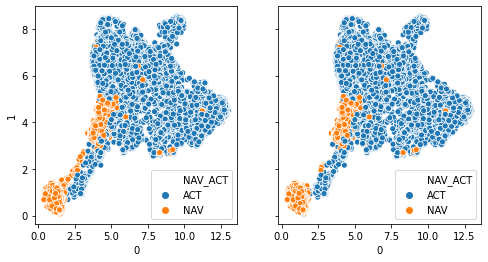

In [98]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb_op, x=0, y=1, hue='NAV_ACT', ax=ax1)

outlier_scores = sklearn.neighbors.LocalOutlierFactor(n_neighbors = 200, contamination=0.01).fit_predict(umap_embedding_originalPCs)
plot_tb_op['outlier_scores'] = outlier_scores
plot_tb_op_rmOutliers = plot_tb_op[plot_tb_op['outlier_scores'] != -1]
sns.scatterplot(data=plot_tb_op_rmOutliers, x=0, y=1, hue='NAV_ACT', ax=ax2)

*NAV v.s. ACT seperate*

<AxesSubplot:xlabel='0', ylabel='1'>

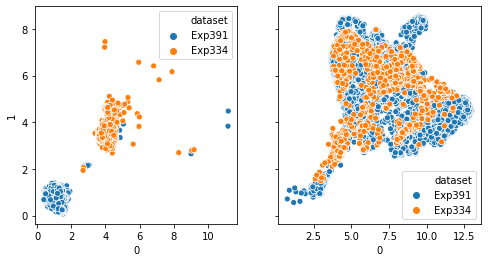

In [99]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.scatterplot(data=plot_tb_op_rmOutliers[plot_tb_op_rmOutliers['NAV_ACT']=='NAV'], x=0, y=1, hue='dataset', ax=ax1)
sns.scatterplot(data=plot_tb_op_rmOutliers[plot_tb_op_rmOutliers['NAV_ACT']=='ACT'], x=0, y=1, hue='dataset', ax=ax2)